# Programming Assignment: Image Denoising
## Name : 백찬희
## Student ID : 20142503
## Github : https://github.com/Baekchanhee/assignment11.git

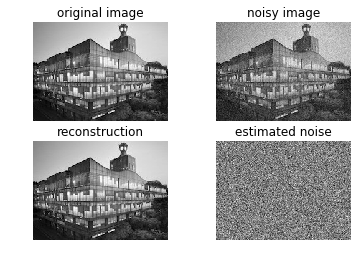

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from skimage import io, color
from skimage import exposure

file_image	= 'cau-1.jpg'

im_color 	= io.imread(file_image)
im_gray  	= color.rgb2gray(im_color)
im          = (im_gray - np.mean(im_gray)) / np.std(im_gray)
(row, col)  = im.shape

noise_std   = 0.2 # try with varying noise standard deviation
noise       = np.random.normal(0, noise_std, (row, col))
im_noise    = im + noise

# obtain the reconstructed (denoised) images with varying degrees of regularization 

im_recon    = im # this must be replaced with the reconstructed (denoised) image 
noise_recon = im_noise - im_recon
error       = np.linalg.norm(im - im_recon)

p1 = plt.subplot(2,2,1)
p1.set_title('original image')
plt.imshow(im, cmap='gray')
plt.axis('off')

p2 = plt.subplot(2,2,2)
p2.set_title('noisy image')
plt.imshow(im_noise, cmap='gray')
plt.axis('off')

p3 = plt.subplot(2,2,3)
p3.set_title('reconstruction')
plt.imshow(im_recon, cmap='gray')
plt.axis('off')

p4 = plt.subplot(2,2,4)
p4.set_title('estimated noise')
plt.imshow(noise_recon, cmap='gray')
plt.axis('off')

plt.show()

# Make noisy image with varying standard deviation

In [3]:
def noisy_image(noise_std):
    noise = np.random.normal(0, noise_std, (row, col))
    im_noise = im + noise
    return im_noise

# Vectorization 

In [4]:
def vectorize(matrix):
    (row, col)  = matrix.shape
    v = np.empty(row * col)
    count = 0
    for j in range(col):
        for i in range(row):
            v[count] = matrix[i][j]
            count += 1
    return v   

# $f = u + n$ 

## $f$ : input image $u$ : clean image (target) $n$ : noise

## minimize $||f - u||^2 + \lambda ||Du||^2$  => reshape it to least square problem $ ||Ax - b||^2 $

## $x = u$(vectorize)

## $ A =  \begin{bmatrix}
  I \\
  \sqrt{\lambda}Dx \\
  \sqrt{\lambda}Dy
 \end{bmatrix} $

## $ b =  \begin{bmatrix}
  f \\
  0 \\
  0
 \end{bmatrix} $

# differential matrix for the vectorized

In [5]:
from scipy import sparse
#sparse.csr_matrix

def dx(matrix):
    (row, col)  = matrix.shape
    dx_row = row * col - row
    dx = np.zeros((dx_row, (row * col)))
    for i in range(dx_row):
        dx[i][i] = -1
        dx[i][i+row] = 1
    dx = sparse.csr_matrix(dx)
    return dx
    
def dy(matrix):
    (row, col)  = matrix.shape
    dy_row = row * col - col
    dy = np.zeros((dy_row, (row * col)))
    count = 0
    for i in range(col):
        for j in range(row - 1):
            dy[count][i+count] = -1
            dy[count][i+count+1] = 1
            count += 1
    dy = sparse.csr_matrix(dy)
    return dy

## test

In [6]:
from scipy.sparse import *
print(dx(np.zeros((3,4))).toarray())   
print(dy(np.zeros((3,5))).toarray())



[[-1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.]]
[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0

# reconstruction  

In [7]:
from scipy import sparse
from scipy.sparse import *

import math
# param = lambda f = input image
def reconstruct(param, f):
    # make A
    i = sparse.eye(f.shape[0] * f.shape[1])  # identity matrix
    pm = math.sqrt(param)
    d_x = pm * dx(f)
    d_y = pm * dy(f)
    A = sparse.vstack([i, d_x, d_y])
    # make b
    b = vectorize(f)
    dx_row = row * col - row
    dy_row = row * col - col
    zeros = np.zeros(dx_row + dy_row)
    b = np.hstack((b,zeros))
    # solve least square problem
    x, nop1, nop2, error = sparse.linalg.lsqr(A,b)[:4]
    
    # vector to matrix
    recon = np.empty((f.shape[0], f.shape[1]))
    count = 0
    for j in range(f.shape[1]):
        for i in range(f.shape[0]):
            recon[i][j] = x[count]
            count +=1
    return recon, error




# Try with varying the noise standard deviation σ and the regularization parameter λ


std: 0.01, lambda: 0.125, error: 28.77028959595458


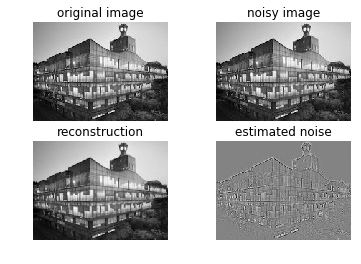

std: 0.01, lambda: 0.25, error: 37.190413169601364


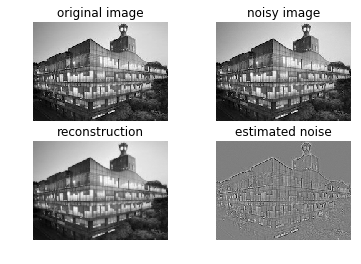

std: 0.01, lambda: 0.5, error: 46.30101960849984


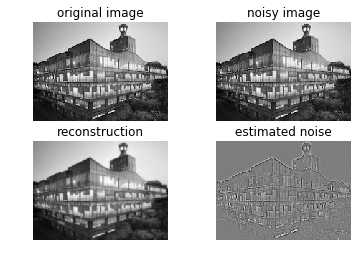

std: 0.01, lambda: 1, error: 55.577643598888265


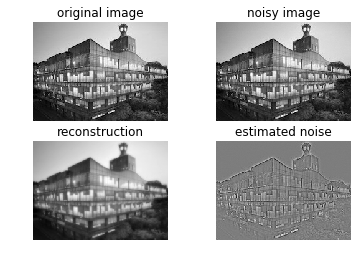

std: 0.01, lambda: 2, error: 64.69442402095567


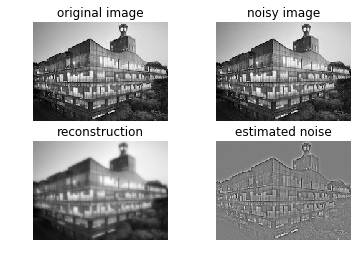

std: 0.01, lambda: 4, error: 73.53697384941877


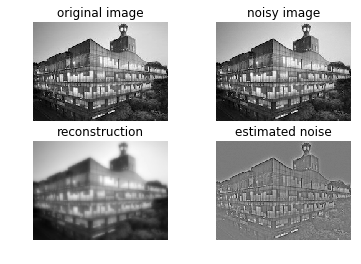

std: 0.01, lambda: 8, error: 82.08977353910817


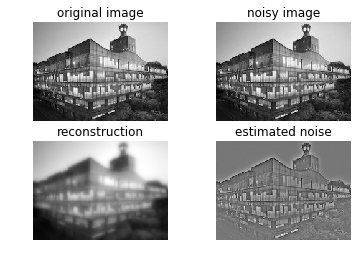

std: 0.01, lambda: 16, error: 90.37465614393082


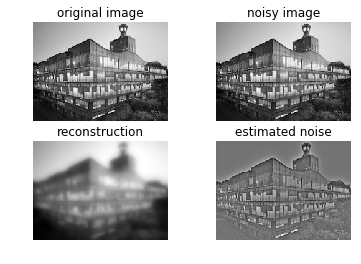

std: 0.01, lambda: 32, error: 98.47814069704842


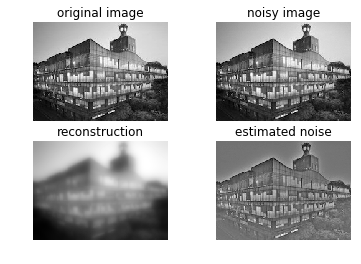

std: 0.1, lambda: 0.125, error: 30.59996019919642


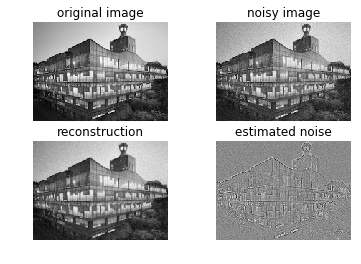

std: 0.1, lambda: 0.25, error: 39.29585803107654


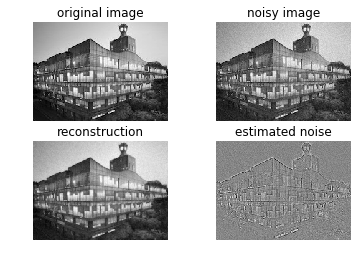

std: 0.1, lambda: 0.5, error: 48.566127489220165


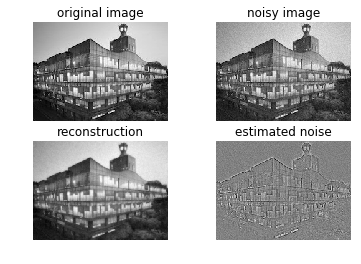

std: 0.1, lambda: 1, error: 57.88211445593116


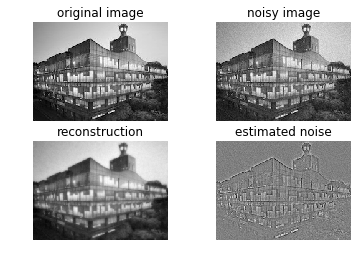

std: 0.1, lambda: 2, error: 66.9495892606283


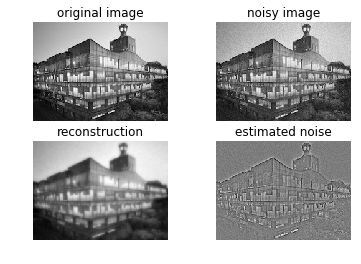

std: 0.1, lambda: 4, error: 75.6934090354654


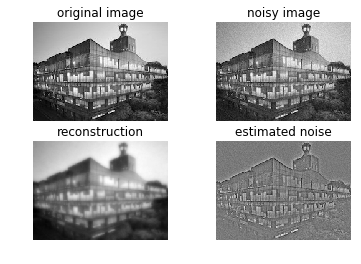

std: 0.1, lambda: 8, error: 84.12655360013879


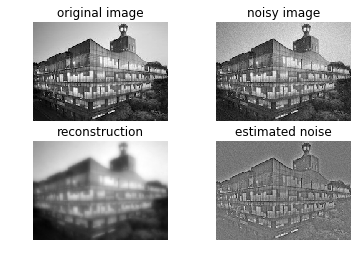

std: 0.1, lambda: 16, error: 92.28601227134455


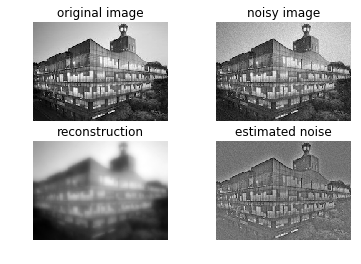

std: 0.1, lambda: 32, error: 100.26548333420003


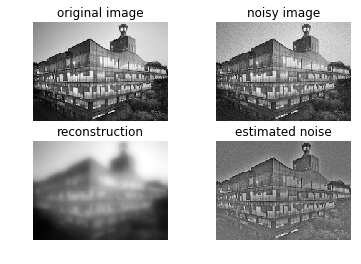

std: 1, lambda: 0.125, error: 107.49891596351952


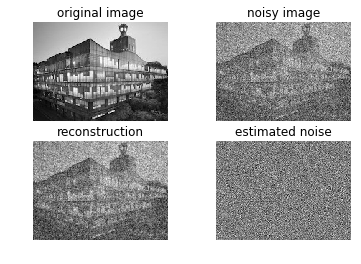

std: 1, lambda: 0.25, error: 131.34626986363287


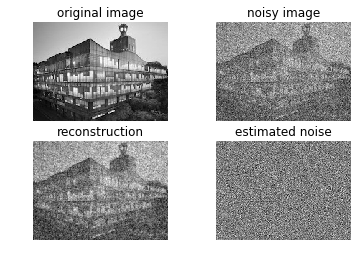

std: 1, lambda: 0.5, error: 152.50574020985277


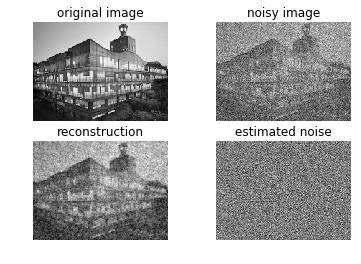

std: 1, lambda: 1, error: 169.37146930547934


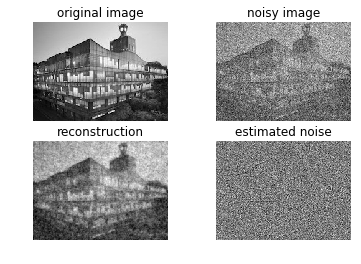

std: 1, lambda: 2, error: 181.96106593643782


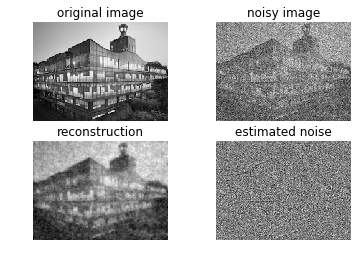

std: 1, lambda: 4, error: 191.22511876324722


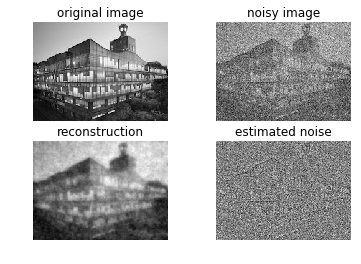

std: 1, lambda: 8, error: 198.26323779459403


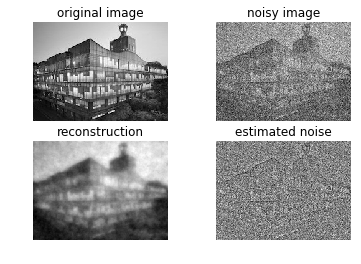

std: 1, lambda: 16, error: 203.9551911182143


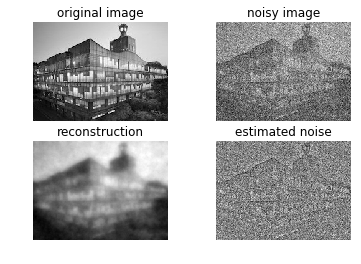

std: 1, lambda: 32, error: 208.9212982493744


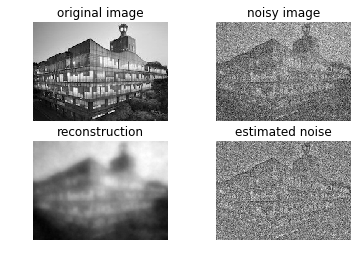

std: 10, lambda: 0.125, error: 1035.5682639960226


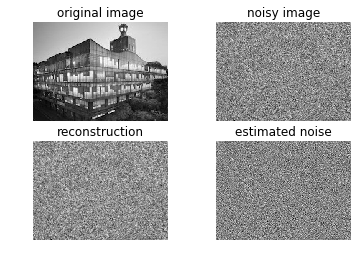

std: 10, lambda: 0.25, error: 1260.17791375914


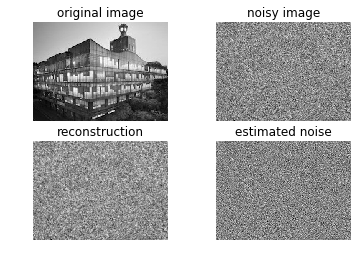

std: 10, lambda: 0.5, error: 1454.3480647247395


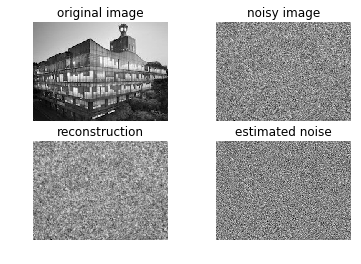

std: 10, lambda: 1, error: 1601.8177999636362


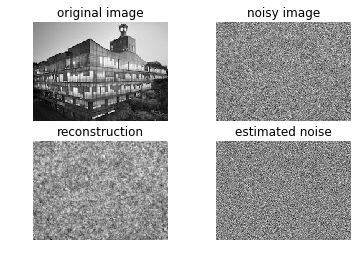

std: 10, lambda: 2, error: 1702.806235092415


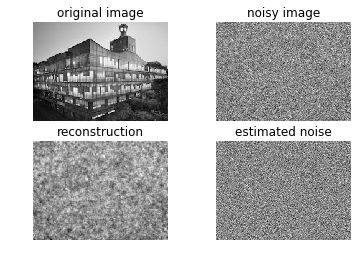

std: 10, lambda: 4, error: 1767.0778284664846


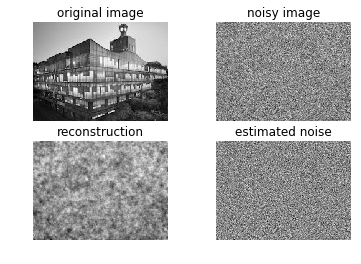

std: 10, lambda: 8, error: 1806.053071170375


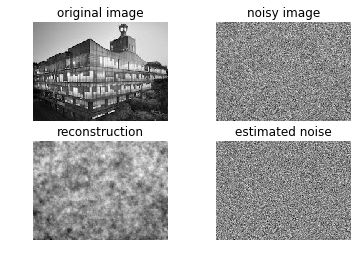

std: 10, lambda: 16, error: 1828.9747460128672


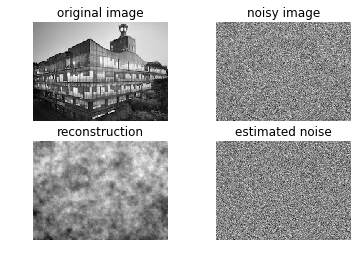

std: 10, lambda: 32, error: 1842.2247010104452


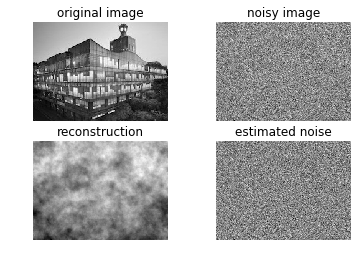

In [8]:
param_list = [2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5]
std_list = [0.01, 0.1, 1, 10]
errors = []
for std in std_list:
    f = noisy_image(std)
    for param in param_list:
        cons_image, error = reconstruct(param, f)
        noise_recon = f - cons_image
        errors.append(error)
        
        print('std: {}, lambda: {}, error: {}'.format(std, param, error))
        p1 = plt.subplot(2,2,1)
        p1.set_title('original image')
        plt.imshow(im, cmap='gray')
        plt.axis('off')

        p2 = plt.subplot(2,2,2)
        p2.set_title('noisy image')
        plt.imshow(f, cmap='gray')
        plt.axis('off')

        p3 = plt.subplot(2,2,3)
        p3.set_title('reconstruction')
        plt.imshow(cons_image, cmap='gray')
        plt.axis('off')

        p4 = plt.subplot(2,2,4)
        p4.set_title('estimated noise')
        plt.imshow(noise_recon, cmap='gray')
        plt.axis('off')
        
        plt.show()

